# Estimate Holland Parameters using Monte Carlo 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fmin_slsqp, least_squares

In [2]:
%matplotlib inline

Define some parameters (see [Parameters.ipynb](./Parameters.ipynb))

In [3]:
from Storms.parameters import *

In [4]:
fk=0.92  # coefficient for going from 1m to 10m in velocities

In [5]:
radcols=['64ne', '64se', '64sw', '64nw', '50ne', '50se', '50sw', '50nw',
       '34ne', '34se', '34sw', '34nw']

In [6]:
cols=['w'+ name for name in radcols]

In [7]:
def hvel(r,dph,bh,rmaxh,kh):
    x=0.5+(r-rmaxh)/(maxR-rmaxh)*kh
    return (bh/rhoa*(rmaxh/r)**bh*dph*np.exp(-(rmaxh/r)**bh))**x

In [8]:
rh=np.linspace(0.01,maxR,100)

### read TC data

In [9]:
path='../tmp/'

In [10]:
tc=pd.read_csv(path+'step2.txt',delimiter='\t')

In [11]:
tc

,time,t,hurName,lat,lon,pcenter,penv,rmax,vmax,34ne,...,w64nw,w50ne,w50se,w50sw,w50nw,w34ne,w34se,w34sw,w34nw,vmax0vt
0,0.0,2016-09-29 12:00:00,MATTHEW,14.2,-65.5,995,-99,68524.0,30.866667,279652.0,...,0.000000,25.685045,0.000000,26.161934,0.000000,20.773219,18.274868,19.534445,20.608431,26.161934
1,1.0,2016-09-29 13:00:00,MATTHEW,14.2,-65.7,998,-99,46300.0,29.323333,288912.0,...,0.000000,25.285722,25.452586,26.058509,0.000000,20.893198,18.110921,19.263473,20.915893,26.058509
2,2.0,2016-09-29 14:00:00,MATTHEW,14.3,-65.9,997,-99,57412.0,33.953333,262984.0,...,0.000000,25.123333,0.000000,26.055893,24.499624,20.452050,18.085768,19.538575,20.351526,30.315362
3,3.0,2016-09-29 15:00:00,MATTHEW,14.3,-66.1,995,-99,48152.0,33.438889,253724.0,...,0.000000,25.204719,25.715476,25.984405,0.000000,20.334297,18.155295,19.796023,20.766386,32.334880
4,4.0,2016-09-29 16:00:00,MATTHEW,14.3,-66.3,993,-99,42596.0,33.953333,266688.0,...,0.000000,25.529823,25.442486,26.288832,0.000000,20.615410,17.985921,20.326892,20.615410,32.122624
5,5.0,2016-09-29 17:00:00,MATTHEW,14.3,-66.4,992,-99,68524.0,31.381111,253724.0,...,0.000000,24.756404,25.264011,26.362415,24.017778,20.333641,20.618972,20.763431,20.727831,26.362415
6,6.0,2016-09-29 18:00:00,MATTHEW,14.4,-66.6,990,-99,72228.0,31.381111,251872.0,...,0.000000,24.722219,25.709742,26.567329,24.041325,20.222630,18.186833,20.189763,20.559208,26.567329
7,7.0,2016-09-29 19:00:00,MATTHEW,14.4,-66.9,990,-99,51856.0,31.381111,257428.0,...,0.000000,25.153531,25.769557,26.408986,0.000000,20.325786,18.345570,20.409975,19.850360,26.408986
8,8.0,2016-09-29 20:00:00,MATTHEW,14.5,-67.1,989,-99,53708.0,32.410000,250020.0,...,0.000000,25.255164,25.152396,26.301417,24.480355,20.210466,17.908814,20.292461,19.585819,26.301417
9,9.0,2016-09-29 21:00:00,MATTHEW,14.6,-67.3,989,-99,44448.0,32.924444,238908.0,...,0.000000,25.026409,25.950845,26.236194,23.907438,20.080951,18.355665,20.423490,18.014881,32.730365


### For one time ... 

In [12]:
it=10

In [13]:
vmax=tc.loc[it].vmax

In [14]:
R=tc.ix[it,radcols].values

In [15]:
V=tc.ix[it,cols].values

In [16]:
vmax0vt = tc.vmax0vt.values[it]

In [17]:
time = tc.time.values[it]

In [18]:
sinfi = tc.sinfi.values[it]

In [19]:
lat=tc.lat.values[it]

In [20]:
w = R > 0.

In [21]:
R = R[w].astype(float)

In [22]:
V = V[w].astype(float)

In [23]:
R,V

(array([  57412.,   61116.,  109268.,   51856.,  107416.,   66672.,
         351880.,   88896.,  266688.,  137048.]),
 array([ 30.38791784,  32.25034585,  25.18648374,  26.01698172,
         25.9469213 ,  23.76780749,  22.14404443,  18.39730013,
         20.10583303,  18.0404132 ]))

## Calculating using Monte Carlo

In [24]:
nb=10000  #size of random numbers used

In [25]:
npmin=2 # minimum number of velocities in order to...

npv=np.size(V)

In [26]:
if (npv>npmin):
     K=kmin+(kmax-kmin)*np.random.rand(nb)
elif(done):
     K = np.ones(nb)*ktot[t-1] # previous time step
else:
     K = np.ones(nb)*kmin

In [27]:
#  DP
DP=dpmin*(dpmax/dpmin)**np.random.rand(nb)

#  Rmax
rvmaxmin_=np.min([rvmaxmin,np.min(R)*0.5])  # update the minimum  value for Rmax with the R.min/2 from input
RMAX=rvmaxmin_*(np.min(R)*0.99/rvmaxmin_)**np.random.rand(nb) # range  min(10000,Rmin/2)<Rmax<.99*Rmin (scaled)

In [28]:
#--------------------------------------------------
# calculate vmax1 = v max0k -vt - Coriolis effect (function of RMAX)
#--------------------------------------------------
deltalatvmax=RMAX/deg2m*sinfi  # for each Rmax we compute the lat deviation for the velocity
latvmax=lat+deltalatvmax

fvmax=2*omega*np.abs(np.sin(np.radians(latvmax))) # Coriolis coef f

fvmax2=RMAX*fvmax/2
vmax1=((vmax0vt+fvmax2)**2-fvmax2**2)**0.5
mask=vmax1<np.max(V)
np.copyto(vmax1,np.max(V),where=mask)

#----------------------------------
# use the random values of vmax,dp above we compute b (from Holland 2010 - eqs (7))
#----------------------------------

B=(rhoa*np.exp(1)/DP)*vmax1**2


m=(B >= bmin) & ( B <= bmax) & (lat*latvmax > 0)  # mask B that fits all 3 criteria
nb1 = np.sum(m) #number of 'True' values

#  mask arrays accordingly
K=K[m]
DP=DP[m]
RMAX=RMAX[m]
B = B[m]

nval = np.size(V)  # number of V > 0
Vcalc = []
RMS = np.zeros(nb1)

#try:
#        r
#except NameError:
#        pass
#else:
#        r=None

# check values for all V
for i in range(nval):
      try:
        r = R[i]
        ratio=(r-RMAX)/(maxR-RMAX)
        X=0.5 + np.min([np.max(ratio,0),1])*K   #compute x using random k  & Rmax
        Vcalc=np.append(Vcalc,((B/rhoa) * DP* (RMAX/r)**B * np.exp(-(RMAX/r)**B))**X)  # compute & store V
      except: print 'sys.exit()'

for i in range (nb1):
      try:
        RMS[i]=np.sqrt(np.average((Vcalc[i::nb1]-V)**2))  # compute deviation from estimated and given values
      except : print 'sys.exit()'

value=nb1
totvalue=nb

# -------------------------------------------------------------------------
# select final velocities
# -------------------------------------------------------------------------
m=RMS == np.min(RMS)  #find minimum RMS

# select the minimizing quantities
rmse=RMS[m][0]
dpMC=DP[m][0]
bMC=B[m][0]
rmaxMC=RMAX[m][0]
kMC=K[m][0]

vmax1MC = np.sqrt(bMC*dpMC/(rhoa*np.exp(1)))  # compute estimated vmax


# print on screen
var=[rmse,dpMC,bMC,rmaxMC,kMC ,np.max(V),vmax1MC]
varn=['rmse','dph','bh','rmaxh','kh','np.max(V)','vmax1']

mcdic={el:val for (el,val) in zip(varn,var)}


In [29]:
mcdic

{'bh': 1.0347207697296461,
 'dph': 3196.1096278671034,
 'kh': 0.21354897048140772,
 'np.max(V)': 32.250345851399999,
 'rmaxh': 15206.811612736439,
 'rmse': 3.4128097697523678,
 'vmax1': 32.52567033623405}

In [30]:
for key,val in mcdic.items():
    try:
        exec(key + '=val') 
    except: pass

## Plot profile

In [31]:
xl=np.linspace(-maxR, maxR,1000)
yl=np.linspace(-maxR, maxR,1000)
q1,q2=np.meshgrid(xl,yl)
vtx=tc.iloc[it].vtrx
vty=tc.iloc[it].vtry

In [32]:
def pres(r):
    return pn+dph*np.exp(-(rmaxh/r)**bh)

In [33]:
def hvel2d(l1,l2):
    r=np.sqrt(l1**2+l2**2)
    xh=0.5+(r-rmaxh)/(maxR-rmaxh)*kh
    ur=(bh/rhoa*(rmaxh/r)**bh*dph*np.exp(-(rmaxh/r)**bh))**xh
    theta=np.arctan2(l2,l1)
    ux=-ur*np.sin(theta)
    uy=ur*np.cos(theta)
    return ux+vtx,uy+vty, pres(r)

In [34]:
zx,zy, pr=hvel2d(q1,q2)
vel=np.sqrt(zx**2+zy**2)

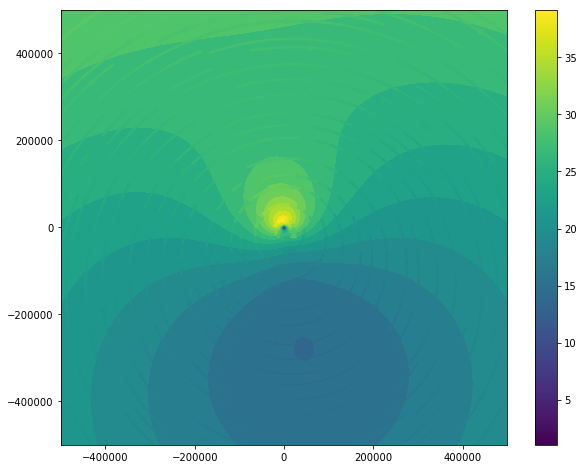

In [35]:
plt.figure(figsize=(10,8))
plt.contourf(q1,q2,vel,20)
plt.streamplot(q1,q2,zx,zy, color=vel, linewidth=0.1*vel)
plt.colorbar()
plt.show()

#  Compute for all time steps

For all times using external scripts

In [36]:
from Storms.mc import mc

In [37]:
varn=['rmse','dph','b','rmaxh','k','np.max(V)','vmax1']
mcdic={el:[] for el in varn}

In [38]:
hpar= pd.DataFrame(mcdic)

In [39]:
for it in range(tc.shape[0]):
   
    vmax=tc.loc[it].vmax

#
#try:
#    dp=tc.loc[it].dp
#except:
#    pass

    R=tc.ix[it,radcols].values

    V=tc.ix[it,cols].values

    vmax0vt = tc.vmax0vt.values[it]

    time = tc.time.values[it]

    sinfi = tc.sinfi.values[it]

    lat=tc.lat.values[it]

    w = R > 0.

    R = R[w].astype(float)

    V = V[w].astype(float)

    if R.size > 0 : 
        rmc = mc(R,V,sinfi,lat,vmax0vt)
    else:
        rmc = {el:'' for el in varn}

    df = pd.DataFrame(rmc,index=[it])

    
    hpar = hpar.append(df)
    

In [40]:
hpar.head()

,b,dph,k,np.max(V),rmaxh,rmse,vmax1
0,0.824513,2687.041711,0.098787,26.161934,26013.373175,3.003832,26.621949
1,0.849102,2575.365636,0.134372,26.058509,21960.064705,2.634959,26.448632
2,1.161375,2532.480755,0.239280,30.315362,19995.524368,2.827389,30.673483
3,1.044077,3184.888911,0.207510,32.334880,15661.528632,3.298494,32.614984
4,1.064447,3095.902038,0.184050,32.122624,19347.964022,3.666758,32.468297


## Write outData file

In [41]:
outData = pd.concat([tc,hpar],axis=1) # append the Monte Carlo solution to tc Dataset

In [42]:
outData.head()

,time,t,hurName,lat,lon,pcenter,penv,rmax,vmax,34ne,...,w34sw,w34nw,vmax0vt,b,dph,k,np.max(V),rmaxh,rmse,vmax1
0,0.0,2016-09-29 12:00:00,MATTHEW,14.2,-65.5,995,-99,68524.0,30.866667,279652.0,...,19.534445,20.608431,26.161934,0.824513,2687.041711,0.098787,26.161934,26013.373175,3.003832,26.621949
1,1.0,2016-09-29 13:00:00,MATTHEW,14.2,-65.7,998,-99,46300.0,29.323333,288912.0,...,19.263473,20.915893,26.058509,0.849102,2575.365636,0.134372,26.058509,21960.064705,2.634959,26.448632
2,2.0,2016-09-29 14:00:00,MATTHEW,14.3,-65.9,997,-99,57412.0,33.953333,262984.0,...,19.538575,20.351526,30.315362,1.161375,2532.480755,0.239280,30.315362,19995.524368,2.827389,30.673483
3,3.0,2016-09-29 15:00:00,MATTHEW,14.3,-66.1,995,-99,48152.0,33.438889,253724.0,...,19.796023,20.766386,32.334880,1.044077,3184.888911,0.207510,32.334880,15661.528632,3.298494,32.614984
4,4.0,2016-09-29 16:00:00,MATTHEW,14.3,-66.3,993,-99,42596.0,33.953333,266688.0,...,20.326892,20.615410,32.122624,1.064447,3095.902038,0.184050,32.122624,19347.964022,3.666758,32.468297


### specify the output format for the outData.txt file in the operational workflow

In [43]:
header=['time','xhc','yhc','b','k','rmax','deltap','vmax','vmax0','vtr','vtrx','vtry','bias','rmse']

In [44]:
outData.columns.values

array(['time', 't', 'hurName', 'lat', 'lon', 'pcenter', 'penv', 'rmax',
       'vmax', '34ne', '34nw', '34se', '34sw', '50ne', '50nw', '50se',
       '50sw', '64ne', '64nw', '64se', '64sw', 'dp', 'vtrx', 'vtry', 'vtr',
       'cosfi', 'sinfi', 'w64ne', 'w64se', 'w64sw', 'w64nw', 'w50ne',
       'w50se', 'w50sw', 'w50nw', 'w34ne', 'w34se', 'w34sw', 'w34nw',
       'vmax0vt', 'b', 'dph', 'k', 'np.max(V)', 'rmaxh', 'rmse', 'vmax1'], dtype=object)

In [45]:
column_order=['time','lat','lon','b','k','rmaxh','dph','vmax','vmax0','vtr','vtrx','vtrxy','bias','rmse']

In [46]:
outData.to_csv('../tmp/outData.txt',index=False, columns=column_order, sep='\t',header=header)

### save the complete dataset as step 3 of the analysis

In [47]:
outData.to_csv(path+'step3.txt',index=False, sep='\t')

## Compare estimations with available values in the read-in dataset

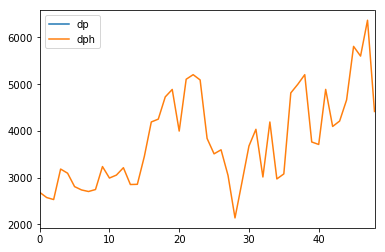

In [48]:
outData[['dp','dph']].apply(pd.to_numeric).plot()

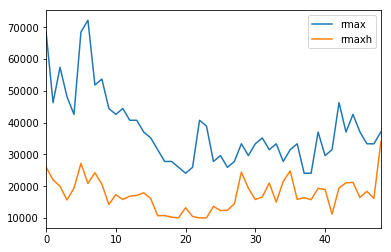

In [49]:
outData[['rmax','rmaxh']].apply(pd.to_numeric).plot()

Now we compute the output fields. See [Output.ipynb](./Output.ipynb)